In [ ]:
include("../examples/BiomassDynamics.jl")
include("../src/BeleifMDPSolvers.jl")
using Plots

# Fisheries model example

Here I test a fisheries model that tracks both the abundance and biomass of a population. Informaiton about the abundace and structure (average size) of the population is used to make harvest decisons. These two sources of inforation refelect a simplified version of the data that is avaiable for stock assessments. Informaiton about the abundace can be used to determine sustainable harvest rates given the popuatlion's productivity. The sturucture of the popualtion influences its productivity over short time scales, because smaller individuals growth faster. 

## set paramters 

In [ ]:
pars = BiomassDynamics.pars_short

In [ ]:
T!(x,Ht) = BiomassDynamics.deterministic!(x,Ht,pars)[1]
T(x,Ht) = BiomassDynamics.deterministic(x,Ht,pars)[1]
function R_obs(x,Ht)
    Fmax = 0.9
    B = exp(x[2])
    if B > Ht  
        s = [Fmax,-log((B-Ht)/B)]
        F = s[argmin(s)]
    else
        F = Fmax
    end
    H = (1-exp(-F))*B
    
    return H - 0.05*F
end
R(x,Ht,Ot) = R_obs(x,Ht)
H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
sigma_R = 0.5
Sigma_N = [10^-6 0 0; 0 10^-6 0; 0 0 sigma_R]
function Sigma_O(a, obs)
    if obs == 0
        return [0.25 0 ; 0 0.05]
    else
        return [2.0 0 ; 0 2.0]
    end
end 

In [ ]:
include("../examples/BiomassDynamics.jl")
Fmsy = BiomassDynamics.Fmsy(pars)[2]
println("MSY: ",round(BiomassDynamics.MSY(pars),digits=2))
println("Fmsy: ", round(Fmsy,digits=2))
println("equilibrium: ", round.(BiomassDynamics.equib(Fmsy, pars),digits=2))     
T_ = 10000
x0 = log.(vcat(BiomassDynamics.equib(Fmsy, pars),1.0))
B = zeros(T_)
N = zeros(T_)
H_ = zeros(T_)
F_ = zeros(T_)
for t in 1:T_
    Ht = exp(x0[2])*(1-exp(-Fmsy))
    x0, Ht, Ft= BiomassDynamics.stochastic(x0, Ht,pars)
    B[t] = exp(x0[2])
    N[t] = exp(x0[1])
    H_[t] = Ht
    F_[t] = Ft
end 
p1=Plots.plot(B[100:300], ylabel ="biomass", grid = false, color = "black",label ="")
p2=Plots.plot(N[100:300], ylabel ="biomass", grid = false, color = "black",label ="")
p3=Plots.plot(H_[100:300], ylabel ="harvest",xlabel="time", grid = false, color = "grey",label ="")
#p4=Plots.plot(F_[100:300], ylabel ="effort",xlabel="time", grid = false, color = "grey",label ="")
plot(p1,p2,p3,layout = (3,1))

In [ ]:
p1=Plots.histogram(B, xlabel = "biomass", grid=false, color="grey",label="")
p2=Plots.histogram(N, xlabel = "numbers", grid=false, color="white",label="")
plot(p1,p2,layout=(1,2))

## Set action space and quadrature grid

In [ ]:
delta= 1/(1+0.1)
actions = collect(0.0:0.25:15)
observations = [0,1]
lower_mu = log.([1.0,0.1])
upper_mu = log.([200,70])

In [ ]:
include("../src/BeleifMDPSolvers.jl")
solver=BeleifMDPSolvers.initSolver(T!,T,R,R_obs,
            H,Sigma_N,Sigma_O,delta,
            actions, observations,
            lower_mu,upper_mu;n_grids_obs = 30,n_grid = 6)

print(" ")

In [ ]:
length(solver.bellmanIntermidiate)

In [ ]:
include("../src/BeleifMDPSolvers.jl")
BeleifMDPSolvers.solve_observed_parallel!(solver;tol = 10^-4)

In [ ]:
A = solver.valueFunction.baseValue.a[1]:0.2:solver.valueFunction.baseValue.b[1]
B = solver.valueFunction.baseValue.a[2]:0.2:solver.valueFunction.baseValue.b[2]

acc_V = zeros(length(A),length(B))
acc_P = zeros(length(A),length(B))
        
i =0 
for a in A
    print(i/length(A), " ")
    i+=1
    Threads.@threads for j in 1:length(B)
        b = B[j]
        acc_V[i,j]=solver.valueFunction.baseValue([a,b])
        acc_P[i,j]=BeleifMDPSolvers.BellmanOpperators.obs_Policy(vcat([a,b],zeros(size(solver.POMDP.Sigma_N)[1] - 2)),
                            solver.obsBellmanIntermidiate[Threads.threadid()],
                            solver.valueFunction.baseValue, 
                            solver.POMDP,solver.optimizer)
    end
end

p1=Plots.heatmap(exp.(B),exp.(A),acc_V)
p2=Plots.heatmap(exp.(B),exp.(A),acc_P)
plot(p1,p2)

## Test POMDP

In [ ]:
include("../src/BeleifMDPSolvers.jl")
include("../src/ValueFunctions.jl")
BeleifMDPSolvers.solve_parallel!(solver;max_iter = 200,tol = 10^-4)

In [ ]:
A = solver.valueFunction.baseValue.a[1]:0.2:solver.valueFunction.baseValue.b[1]

acc_V1 = zeros(length(A))
acc_V2 = zeros(length(A))      
i =0 
Threads.@threads for i in 1:length(A)
    a = A[i]
    acc_V[i,j]=solver.valueFunction.baseValue([a,b])
    acc_V1[i]=solver.valueFunction(zeros(5),([a,a+log(0.3)],[2.0 0.9; 0.9 2.0]))
    acc_V2[i]=solver.valueFunction(zeros(5),([a,a+log(0.3)],[0.5 0.9; 0.9 0.5]))
end


In [ ]:
Plots.plot(exp.(A.+log(0.3)),acc_V1)
Plots.plot!(exp.(A.+log(0.3)),acc_V2)

In [ ]:
Cov = solver.POMDP.Sigma_N
Cov[1:2,1:2] = [2.0 0.0; 0.0 2.0]
A = solver.valueFunction.baseValue.a[1]:0.5:solver.valueFunction.baseValue.b[1]
B = solver.valueFunction.baseValue.a[2]:0.5:solver.valueFunction.baseValue.b[2]

acc_H = zeros(length(A),length(B))
    
i=0
for a in A
    i+=1
    for j in 1:length(B)
        b = B[j]
        acc_H[i,j]=BeleifMDPSolvers.BellmanOpperators.Policy!(([a,b,0.0],Cov),
                                    solver.bellmanIntermidiate[1],
                                    solver.valueFunction, 
                                    solver.POMDP,solver.optimizer)[2]
    end 
end 
Plots.heatmap(acc_H)

# Test model with biomass and average weight

In [1]:
include("../examples/BiomassDynamics2.jl")
include("../examples/BiomassDynamics.jl")
using Plots
using Distributions

In [2]:
pars = BiomassDynamics2.pars_short

(0.8, 1.0, 0.01, 0.215, 2.4, 0.02, 0.2, 0.95)

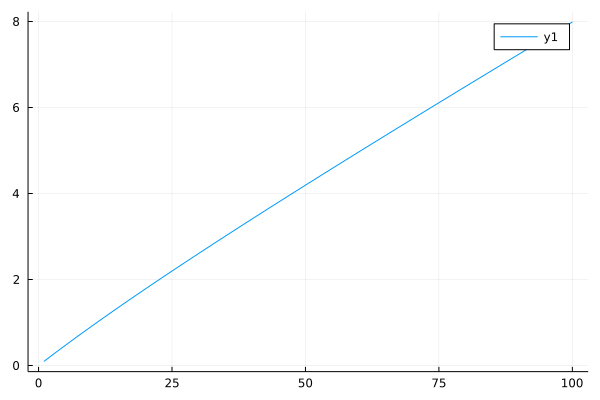

In [3]:
Plots.plot(broadcast(x -> BiomassDynamics2.excess_production([x/0.3537,x],pars),1:100))

In [40]:
T!(x,Ht) = BiomassDynamics2.deterministic!(x,Ht,pars)[1]
T(x,Ht) = BiomassDynamics2.deterministic(x,Ht,pars)[1]
function R_obs(x,Ht)
    Fmax = 0.7
    B = exp(x[1])
    if B > Ht  
        s = [Fmax,-log((B-Ht)/B)]
        F = s[argmin(s)]
    else
        F = Fmax
    end
    H = (1-exp(-F))*B
    return log(H)
end
R(x,Ht,Ot) = R_obs(x,Ht) - log(2.0)*Ot
H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
sigma_R = 0.25
Sigma_N = [10^-6 0 0; 0 10^-6 0; 0 0 sigma_R]
function Sigma_O(a, obs)
    if obs == 2
        return [0.1 0 ; 0 0.025]
    elseif obs == 1
        return [1.0 0 ; 0 0.1]
    else
        return [10.0 0 ; 0 5.0]
    end
end 

Sigma_O (generic function with 1 method)

MSY: 0.05
Fmsy: 0.2
equilibrium: [41.33, 0.27]
Mean effort: 0.20199999999999999


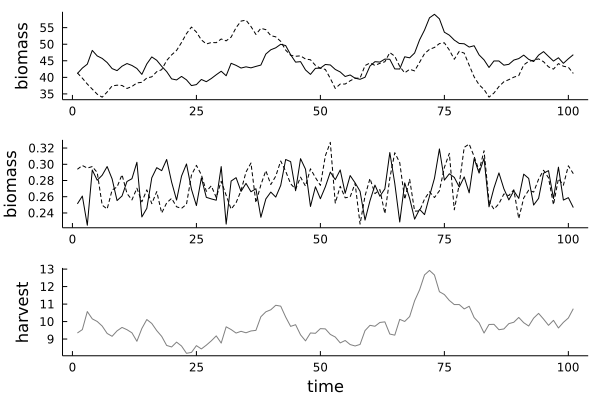

In [41]:

#Fmsy = BiomassDynamics2.Fmsy(pars)[2]
Fmsy = 0.2
println("MSY: ",round(BiomassDynamics2.MSY(pars),digits=2))
println("Fmsy: ", round(Fmsy,digits=2))
println("equilibrium: ", round.(BiomassDynamics2.equib(Fmsy, pars),digits=2))     
T_ = 10000
x0 = log.([100,0.1,1.0])
x1 = log.([100,0.1,1.0])
B = zeros(T_)
Wbar = zeros(T_)
B1 = zeros(T_)
Wbar1 = zeros(T_)
H_ = zeros(T_)
F_ = zeros(T_)
for t in 1:T_
    Ht = exp(x0[1])*(1-exp(-Fmsy))
    B[t] = exp(x0[1])
    Wbar[t] = exp(x0[2])
    B1[t] = exp(x1[1])
    Wbar1[t] = exp(x1[2])
    x0, Ht, Ft= BiomassDynamics2.stochastic(x0, Ht,pars)
    Ht1 = exp(x1[1])*(1-exp(-Fmsy))
    x1 = T(x1,Ht1)
    x1[3] = rand(Distributions.Normal(0,pars[7]))
    H_[t] = Ht
    F_[t] = Ft
end 
p1=Plots.plot(B[100:200], ylabel ="biomass", grid = false, color = "black",label ="")
Plots.plot!(B1[100:200], ylabel ="biomass", grid = false, color = "black",label ="", linestyle = :dash)
p2=Plots.plot(Wbar[100:200], ylabel ="weight", grid = false, color = "black",label ="")
Plots.plot!(Wbar1[100:200], ylabel ="biomass", grid = false, color = "black",label ="", linestyle = :dash)
p3=Plots.plot(H_[100:200], ylabel ="harvest",xlabel="time", grid = false, color = "grey",label ="")
#p4=Plots.plot(F_[100:300], ylabel ="effort",xlabel="time", grid = false, color = "grey",label ="")
println("Mean effort: ", sum(F_[100:200])/100)
plot(p1,p2,p3,layout = (3,1))

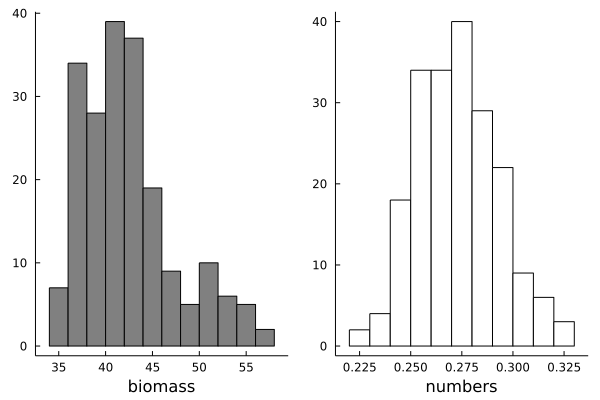

In [42]:
p1=Plots.histogram(B1[100:300], xlabel = "biomass", grid=false, color="grey",label="")
p2=Plots.histogram(Wbar1[100:300], xlabel = "numbers", grid=false, color="white",label="")
plot(p1,p2,layout=(1,2))

In [43]:
delta= 1/(1+0.05)
actions = collect(0.0:0.125:5.0).^2
observations = [0,1,2]
lower_mu = log.([1.0,0.20])
upper_mu = log.([200,0.5])

2-element Vector{Float64}:
  5.298317366548036
 -0.6931471805599453

In [44]:
include("../src/BeleifMDPSolvers.jl")
solver=BeleifMDPSolvers.initSolver(T!,T,R,R_obs,
            H,Sigma_N,Sigma_O,delta,
            actions, observations,
            lower_mu,upper_mu;n_grids_obs = 15,n_grid = 5)

length(solver.bellmanIntermidiate)

12

In [45]:
BeleifMDPSolvers.solve_observed_parallel!(solver;tol = 10^-3)

here1 225.22499999999997
2 1125.5035698009087
3 893.2383367868396
4 742.4320053500917
5 623.8368156163402
6 536.5155634988763
7 462.5708313653561
8 394.50759461429953
9 337.6279036757838
10 289.10500624016794
11 246.01371266659095
12 209.8060133124443
13 179.30852811994316
14 156.05427874928898
15 138.3867816743642
16 124.46971726447197
17 114.73809298715716
18 107.0884540961506
19 96.69002647216641
20 91.00880781343272
21 84.65397618602759
22 78.35982056576266
23 73.65880022225136
24 68.94960385972364
25 62.984897064461144
26 56.68426451646907
27 51.38188788784798
28 47.29716523382695
29 43.934281160525124
30 40.83233160050305
31 37.7399557847976
32 34.583973035997325
33 31.39918971896654
34 28.280688849952817
35 25.352424148320765
36 22.721829830224678
37 20.43677140854297
38 18.478947179780796
39 16.789883000330047
40 15.30205891019994
41 13.958236593549605
42 12.718828496660787
43 11.562171723617992
44 10.480914136177985
45 9.47630139263331
46 8.552176673385008
47 7.710530395709736

"two stage VFI: Observed model solved"

0.0 0.037037037037037035 0.07407407407407407 0.1111111111111111 0.14814814814814814 0.18518518518518517 0.2222222222222222 0.25925925925925924 0.2962962962962963 0.3333333333333333 0.37037037037037035 0.4074074074074074 0.4444444444444444 0.48148148148148145 0.5185185185185185 0.5555555555555556 0.5925925925925926 0.6296296296296297 0.6666666666666666 0.7037037037037037 0.7407407407407407 0.7777777777777778 0.8148148148148148 0.8518518518518519 0.8888888888888888 0.9259259259259259 0.9629629629629629 

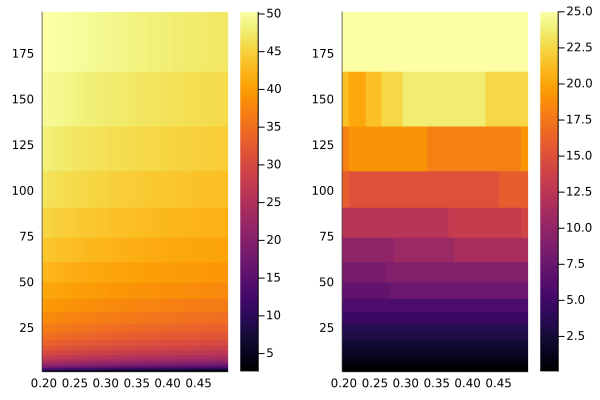

In [46]:
A = solver.valueFunction.baseValue.a[1]:0.2:solver.valueFunction.baseValue.b[1]
B = solver.valueFunction.baseValue.a[2]:0.025:solver.valueFunction.baseValue.b[2]

acc_V = zeros(length(A),length(B))
acc_P = zeros(length(A),length(B))
        
i =0 
for a in A
    print(i/length(A), " ")
    i+=1
    Threads.@threads for j in 1:length(B)
        b = B[j]
        acc_V[i,j]=solver.valueFunction.baseValue([a,b])
        acc_P[i,j]=BeleifMDPSolvers.BellmanOpperators.obs_Policy(vcat([a,b],zeros(size(solver.POMDP.Sigma_N)[1] - 2)),
                            solver.obsBellmanIntermidiate[Threads.threadid()],
                            solver.valueFunction.baseValue, 
                            solver.POMDP,solver.optimizer)
    end
end

p1=Plots.heatmap(exp.(B),exp.(A),acc_V)
p2=Plots.heatmap(exp.(B),exp.(A),acc_P)
plot(p1,p2)

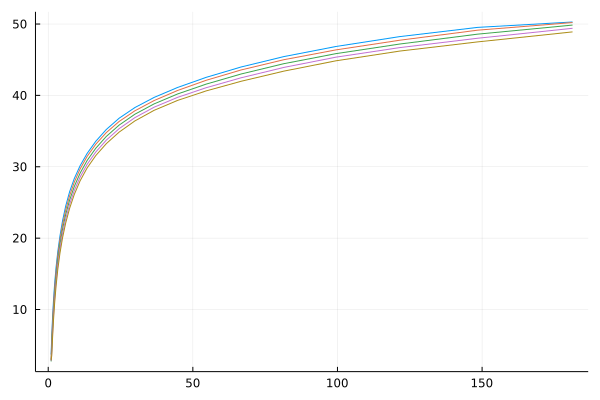

In [47]:
Plots.plot(exp.(A),acc_V[:,1])
Plots.plot!(exp.(A),acc_V[:,5])
Plots.plot!(exp.(A),acc_V[:,10])
Plots.plot!(exp.(A),acc_V[:,15])
Plots.plot!(exp.(A),acc_V[:,20], legend = false)

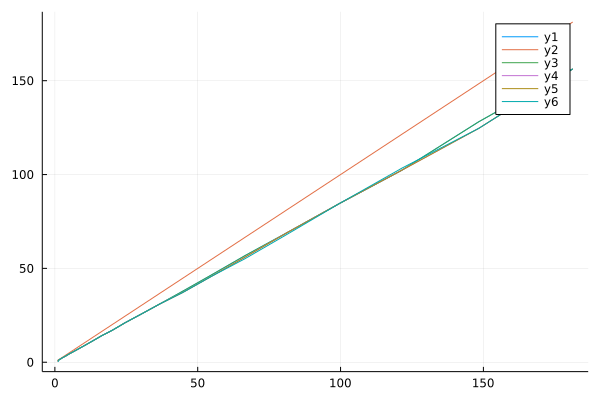

In [48]:
Plots.plot(exp.(A), exp.(A) .- acc_P[:,5])
Plots.plot!(exp.(A),exp.(A))
Plots.plot!(exp.(A), exp.(A) .- acc_P[:,5])
Plots.plot!(exp.(A), exp.(A) .- acc_P[:,18])
Plots.plot!(exp.(A), exp.(A) .- acc_P[:,20])
Plots.plot!(exp.(A), exp.(A) .- acc_P[:,30])

##  Time series under optimal policy 

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

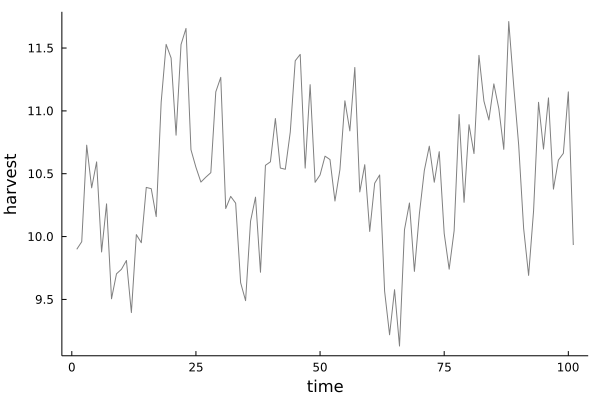

In [49]:
T_ = 200
x0 = log.([100,0.3,1.0])
B = zeros(T_)
Wbar = zeros(T_)
H_ = zeros(T_)
F_ = zeros(T_)
for t in 1:T_
    print(t, " ")
    Ht = BeleifMDPSolvers.BellmanOpperators.obs_Policy(vcat([x0[1],x0[2]],zeros(size(solver.POMDP.Sigma_N)[1] - 2)),
                            solver.obsBellmanIntermidiate[1],
                            solver.valueFunction.baseValue, 
                            solver.POMDP,solver.optimizer)
    B[t] = exp(x0[1])
    Wbar[t] = exp(x0[2])
    x0, Ht, Ft= BiomassDynamics2.stochastic(x0, Ht,pars)
    H_[t] = Ht
    F_[t] = Ft
end 
p1=Plots.plot(B[100:200], ylabel ="biomass", grid = false, color = "black",label ="")
p2=Plots.plot(Wbar[100:200], ylabel ="weight", grid = false, color = "black",label ="")
p3=Plots.plot(H_[100:200], ylabel ="harvest",xlabel="time", grid = false, color = "grey",label ="")

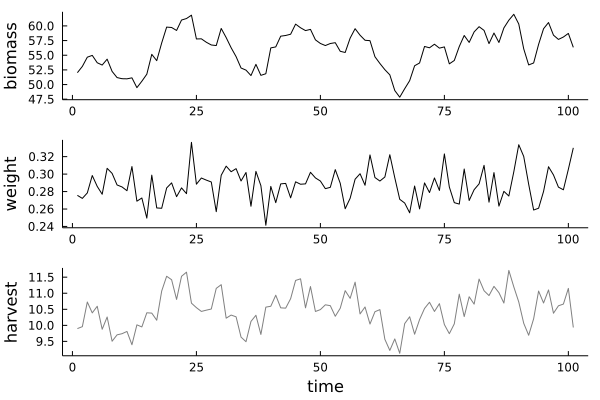

In [50]:
plot(p1,p2,p3,layout = (3,1))

In [51]:
BeleifMDPSolvers.solve_parallel!(solver;max_iter = 30,tol = 10^-3)

0 3128.1249999999995
1 3.2485576576846135e6
2 832.5676107878785
3 365.2174268767591
4 161.2088402295459
5 72.47724671633543
6 30.559783210477672
7 15.857643294342722
8 10.80360106300926
9 8.118503074105877
10 6.4015478889949495
11 4.846595295564548
12 3.539679201521618


"two stage VFI: full model solved"

In [52]:
using JLD2
@save "Biomass_dynamics_solution_log.jld2"  solver
#@load "Biomass_dynamics_solution_1.jld2"  solver

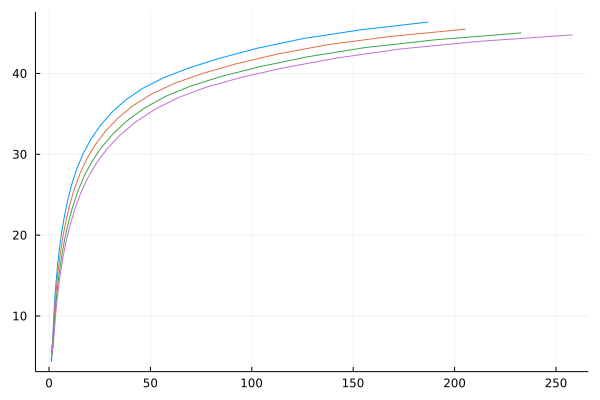

In [53]:
A = solver.valueFunction.baseValue.a[1]:0.2:solver.valueFunction.baseValue.b[1]

acc_V = zeros(length(A))
acc_V1 = zeros(length(A))
acc_V2 = zeros(length(A))      
acc_V3 = zeros(length(A))  
acc_V4 = zeros(length(A)) 
i =0 

Threads.@threads for i in 1:length(A)
    a = A[i]
    acc_V[i]=solver.valueFunction.baseValue([a,0.3])
    acc_V1[i]=solver.valueFunction(zeros(5),([a,log(0.4)],[0.25 0.0; 0.0 0.05]))
    acc_V2[i]=solver.valueFunction(zeros(5),([a,log(0.4)],[0.25^(1/2) 0.0; 0.0 0.05]))
    acc_V3[i]=solver.valueFunction(zeros(5),([a,log(0.4)],[0.25^(1/4) 0.0; 0.0 0.05]))
     acc_V4[i]=solver.valueFunction(zeros(5),([a,log(0.4)],[0.25^(1/8) 0.0; 0.0 0.05]))       
end

  
Plots.plot(exp.(A.+ 0.5*0.25^2 ),acc_V1)
Plots.plot!(exp.(A.+ 0.5*0.25),acc_V2)
Plots.plot!(exp.(A.+ 0.5*0.25^(1/2)),acc_V3, legend = false)
Plots.plot!(exp.(A.+ 0.5*0.25^(1/4)),acc_V4, legend = false)

In [54]:
Cov1 = solver.POMDP.Sigma_N
Cov2 = solver.POMDP.Sigma_N
Cov3 = solver.POMDP.Sigma_N
Cov4 = solver.POMDP.Sigma_N
Cov5 = solver.POMDP.Sigma_N
solver.POMDP.Sigma_N[1:2,1:2] = [10^-6 0; 0 10^-6]
Cov = ([0.25 0.0; 0.0 0.05],[0.5 0.0; 0.0 0.1],[1.0 0.0; 0.0 0.1],[2.0 0.0; 0.0 0.2],[8.0 0.0; 0.0 0.5])
Cov_base = [10^-6 0 0 ; 0 10^-6 0; 0 0 0.5]
A = solver.valueFunction.baseValue.a[1]:0.1:solver.valueFunction.baseValue.b[1]

acc_H = zeros(length(A),5)
acc_O = zeros(length(A),5)
        
i=0
for a in A
    i+=1
    print(i)
    for j in 1:5
        b = B[j]
        Cov_base[1:2,1:2] = Cov[j]
        acc_H[i,j],acc_O[i,j]=BeleifMDPSolvers.BellmanOpperators.Policy!(([a,log(0.25),0.0],Cov_base),
                                    solver.bellmanIntermidiate[1],
                                    solver.valueFunction, 
                                    solver.POMDP,solver.optimizer)
    end 
end 


1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253

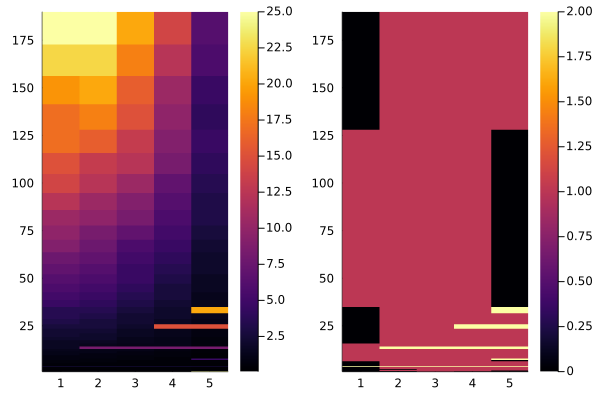

In [55]:
p1=Plots.heatmap(1:5,exp.(A),acc_H)
p2=Plots.heatmap(1:5,exp.(A),acc_O)
plot(p1,p2)

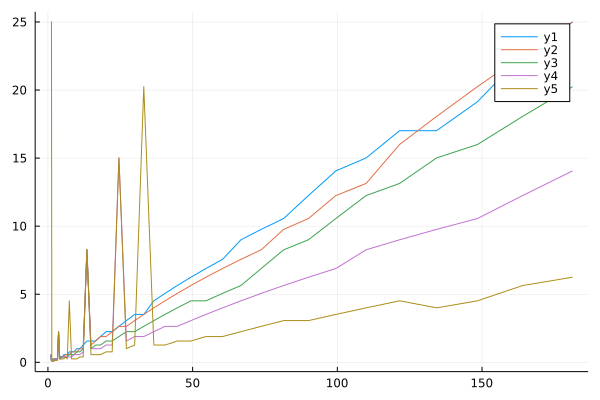

In [56]:
Plots.plot(exp.(A.+0.5*0.25^(2)),acc_H[:,1])
Plots.plot!(exp.(A.+0.5*0.25^(1).+0.5*0.25^(1/4)),acc_H[:,2])
Plots.plot!(exp.(A.+0.5*0.25^(1/2)),acc_H[:,3])
Plots.plot!(exp.(A.+0.5*0.25^(1/4)),acc_H[:,4])
Plots.plot!(exp.(A.+0.5*0.25^(1/4)),acc_H[:,5])

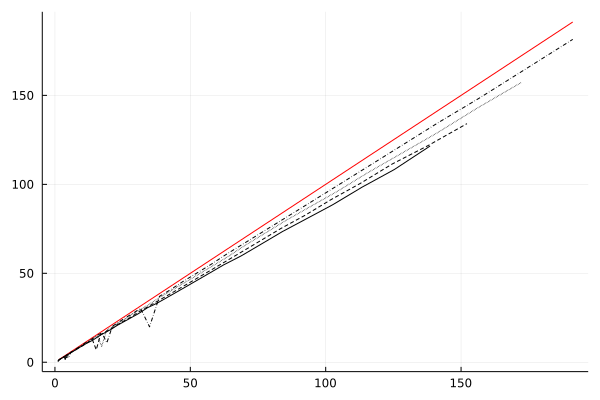

In [57]:

Plots.plot(exp.(A[1:50].+0.5*0.25^(1/4)),exp.(A[1:50].+0.5*0.25^(1/4)), label ="", color = "red")
Plots.plot!(exp.(A[1:50].+0.5*0.25^2), exp.(A[1:50].+0.5*0.25^2) .- acc_H[1:50,1], label ="",
color = "black", linestyle = :solid)
Plots.plot!(exp.(A[1:50].+0.5*0.25), exp.(A[1:50].+0.5*0.25) .- acc_H[1:50,2], label ="",
color = "black", linestyle = :dash)
Plots.plot!(exp.(A[1:50].+0.5*0.25^(1/2)), exp.(A[1:50].+0.5*0.25^(1/2)) .- acc_H[1:50,3], label ="",
color = "black", linestyle = :dot)
Plots.plot!(exp.(A[1:50].+0.5*0.25^(1/4)), exp.(A[1:50].+0.5*0.25^(1/4)) .- acc_H[1:50,4], label ="",
color = "black", linestyle = :dashdot)

In [ ]:
value_expectation!(([log(60),log(0.3),0.0],Cov[j]), a, obs, data, POMDP, V) 
BeleifMDPSolvers.BellmanOpperators.Policy!(([a,log(0.3),0.0],Cov[j]),
                                    solver.bellmanIntermidiate[1],
                                    solver.valueFunction, 
                                    solver.POMDP,solver.optimizer)

In [ ]:
solver.POMDP.Sigma_N

In [ ]:
solver.POMDP.Sigma_O(0,2)